Importing necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

Importing the CIFAR-10 dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Defining number of samples per class

In [3]:
samples_per_class = 30

Right now, x_train and y_train contains all the training data. But we only want small samples per class. So now we'll select the indices for the samples to be used as x_train and y_train

In [4]:
selected_sample_indices = []
for class_label in range(10):   #range is 10 because of 10 total classes.
    class_indices = np.where(y_train == class_label)[0][:samples_per_class]
    selected_sample_indices.extend(class_indices)

x_train = x_train[selected_sample_indices]  #assigning new x_train and y_train
y_train = y_train[selected_sample_indices]


We will now normalize the training data

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Now making the Resnet 18 architecture

In [6]:
def resnet_block(input_layer, filters, kernel_size=3, strides=(1, 1), activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

In [8]:
def resnet18(input_shape=(32, 32, 3), num_classes=10):
    input_layer = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Stack residual blocks
    for _ in range(2):
        x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=(2, 2))
    for _ in range(3):
        x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=(2, 2))
    for _ in range(3):
        x = resnet_block(x, 256)
    x = resnet_block(x, 512, strides=(2, 2))
    for _ in range(2):
        x = resnet_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x)
    return model


Creating a model and compiling it

In [9]:
model = resnet18(input_shape=(32, 32, 3), num_classes=10)


In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Training the model

In [11]:
history = model.fit(x_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
15/15 [==============================] - 8s 250ms/step - loss: 2.7775 - accuracy: 0.1875 - val_loss: 2.3849 - val_accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 3s 217ms/step - loss: 2.1873 - accuracy: 0.1708 - val_loss: 2.5798 - val_accuracy: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 3s 232ms/step - loss: 1.8669 - accuracy: 0.2750 - val_loss: 2.8897 - val_accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 3s 219ms/step - loss: 1.7219 - accuracy: 0.3458 - val_loss: 3.2955 - val_accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 3s 218ms/step - loss: 1.5666 - accuracy: 0.4000 - val_loss: 3.7720 - val_accuracy: 0.0000e+00
Epoch 6/50
15/15 [==============================] - 3s 217ms/step - loss: 1.3318 - accuracy: 0.5042 - val_loss: 4.2655 - val_accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 3s 209ms/step - loss: 1.2391 - accuracy: 0.5583 - val_loss: 4.8042 - val

Model Evaluation

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

313/313 [==============================] - 11s 35ms/step - loss: 5.1541 - accuracy: 0.2513
Test Accuracy: 25.13%


Weight magnitudes

In [13]:
for layer in model.layers:
    if len(layer.weights) > 0:
        print(f"{layer.name}: Mean weight magnitude = {np.mean(np.abs(layer.get_weights()[0]))}")

conv2d: Mean weight magnitude = 0.024045342579483986
batch_normalization: Mean weight magnitude = 0.9991728067398071
conv2d_1: Mean weight magnitude = 0.03826380893588066
batch_normalization_1: Mean weight magnitude = 0.9995050430297852
conv2d_2: Mean weight magnitude = 0.03835536539554596
batch_normalization_2: Mean weight magnitude = 1.0000932216644287
conv2d_3: Mean weight magnitude = 0.03203833848237991
batch_normalization_3: Mean weight magnitude = 1.0001749992370605
conv2d_4: Mean weight magnitude = 0.027918295934796333
batch_normalization_4: Mean weight magnitude = 0.9993404150009155
conv2d_5: Mean weight magnitude = 0.027594082057476044
batch_normalization_5: Mean weight magnitude = 0.9999703168869019
conv2d_6: Mean weight magnitude = 0.02720451168715954
batch_normalization_6: Mean weight magnitude = 0.9992107152938843
conv2d_7: Mean weight magnitude = 0.0222642719745636
batch_normalization_7: Mean weight magnitude = 0.9991682767868042
conv2d_8: Mean weight magnitude = 0.019087

Kernel visualization

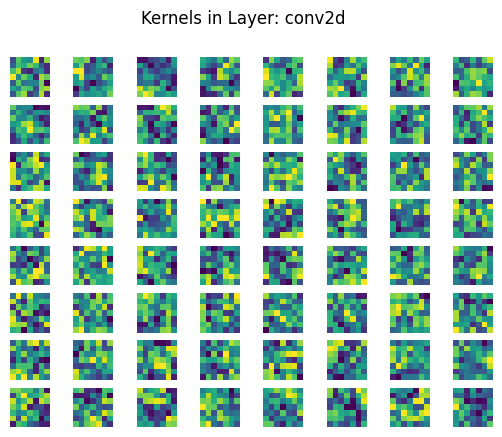

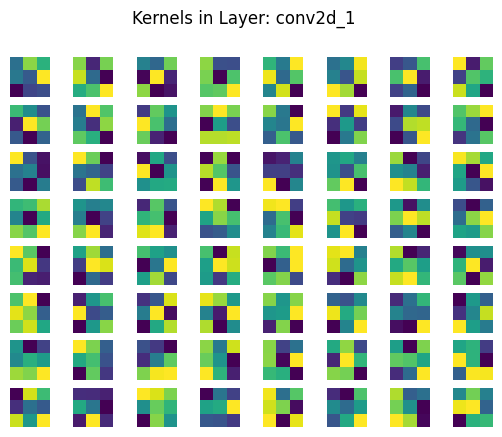

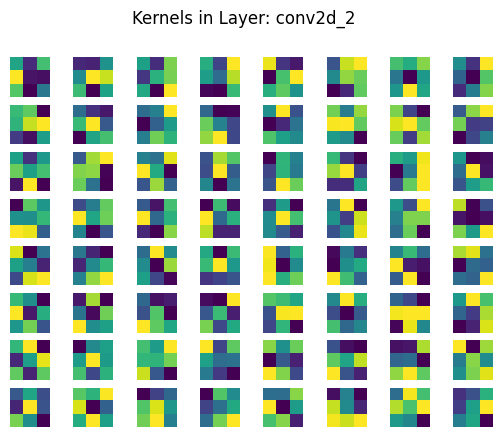

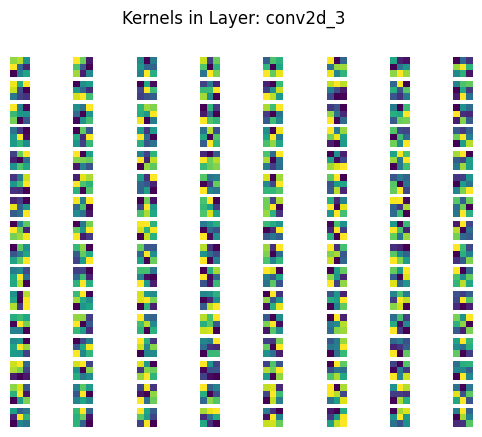

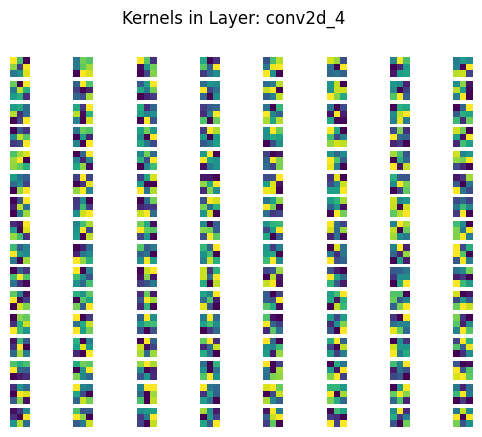

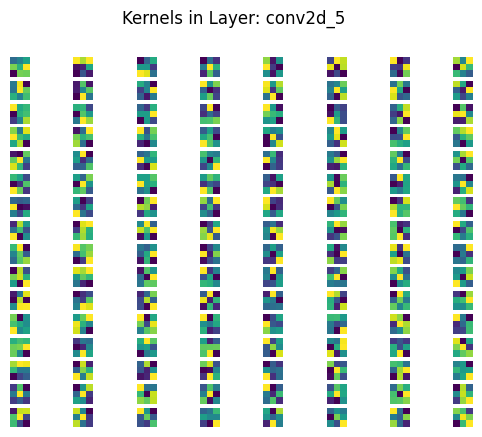

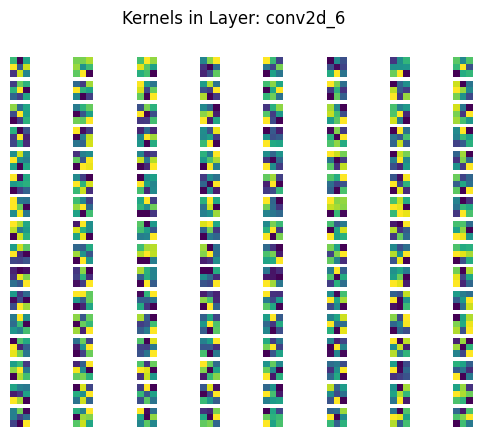

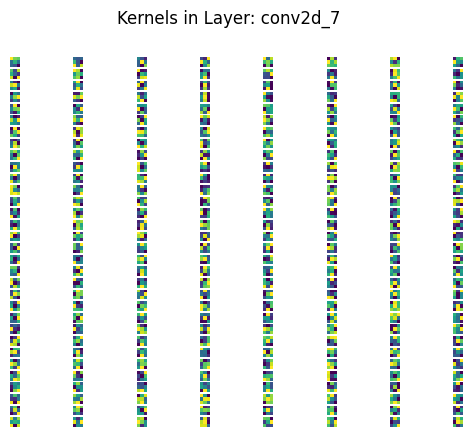

In [15]:
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6', 'conv2d_7']
for layer_name in layer_names:
    layer = model.get_layer(layer_name)
    weights = layer.get_weights()[0]
    num_kernels = weights.shape[-1]
    for i in range(num_kernels):
        plt.subplot(num_kernels //8, 8, i + 1)
        plt.imshow(weights[:, :, 0, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Kernels in Layer: {layer_name}')
    plt.show()